# Description

In the previous notebook, we found that LV603 gene weight's are predictive of gene associations for neutrophil counts.
In a real application, you would run the `GLSPhenoplier` for your trait of interested across all LVs in our models, and get the significant ones. Then you can see in which cell types the LV's genes are expressed, and this is what we are going to do in this notebook for LV603.

To find the cell types associated with an LV, we'll use the matrix B (see our manuscript).
We can connected samples in matrix B with gene expression metadata and explore which cell types are associated with the LV.
However, metadata in gene expression datasets is usually hard to read, process and interpret.
For example, for some samples that could be important for our LV, we might not have access to the cell types where the expriments were conducted. We'll show here what we can do to try to overcome this.

# Modules

In [1]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [2]:
LV_NAME = "LV603"

In [3]:
# LV_AXIS_THRESHOLD = 3.0
# N_TOP_SAMPLES = 400
# N_TOP_ATTRS = 25

In [4]:
OUTPUT_FIGURES_DIR = Path(conf.RESULTS_DIR, "demo", f"{LV_NAME.lower()}").resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/opt/phenoplier_data/results/demo/lv603')

In [5]:
# this is the path of the figure that we will generate, in case you want to export it
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/opt/phenoplier_data/results/demo/lv603/lv603-cell_types.svg')

# Load MultiPLIER summary

In [6]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [7]:
multiplier_model_summary.shape

(2157, 5)

In [8]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## LV data

In [9]:
lv_obj = LVAnalysis(LV_NAME)  # FIXME: does it work without data as argument?

In [10]:
lv_obj.lv_genes.head(20)

,gene_name,LV603,gene_band
0,CXCR2,5.320459,2q35
1,FCGR3B,5.128372,1q23.3
2,TNFRSF10C,5.035457,8p21.3
3,VNN2,4.680865,6q23.2
4,ZDHHC18,4.495976,1p36.11
5,MNDA,4.488505,1q23.1
6,CXCR1,4.442062,2q35
7,P2RY13,4.404405,3q25.1
8,VNN3,4.253184,6q23.2
9,FPR2,4.187560,19q13.41


In [11]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        & (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-10-08 15:16:17,808 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR
1511,IRIS_Neutrophil-Resting,603,0.905751,8.355936e-38,4.505939e-35
1512,SVM Neutrophils,603,0.979789,2.856571e-11,1.432936e-09
1513,PID_IL8CXCR2_PATHWAY,603,0.810732,8.814671e-04,7.041943e-03
1516,SIG_PIP3_SIGNALING_IN_B_LYMPHOCYTES,603,0.769292,3.387907e-03,1.948724e-02


In [12]:
lv_data = lv_obj.get_experiments_data()

SRP051688, SRP059959, SRP045500, SRP044593, SRP048971, SRP015360, SRP056159, SRP059695, SRP026331, SRP051848, SRP062966, SRP017138, SRP022133, SRP059039, SRP059172, SRP058237, SRP043080, SRP056443, SRP034732, SRP055874, SRP041620, SRP056784, 

/opt/phenoplier_code/libs/data/recount2.py:323: UserWarning: Not all experiments data could be loaded (21 != 22)
  warnings.warn(


In [13]:
lv_data.shape

(1141, 50)

In [14]:
lv_data.head()

time                 cell type    assay        donor  \
project   run                                                               
SRP051688 SRR1740034  0 d     primary human B cells  RNA-seq  Donor: HD30   
          SRR1740035  1 d     primary human B cells  RNA-seq  Donor: HD30   
          SRR1740036  3 d     primary human B cells  RNA-seq  Donor: HD30   
          SRR1740037  7 d     primary human B cells  RNA-seq  Donor: HD30   
          SRR1740038  0 d  primary human myeloid DC  RNA-seq  Donor: HD30   

                     tissue passages  age cellcount celltype collectiondate  \
project   run                                                                 
SRP051688 SRR1740034    NaN      NaN  NaN       NaN      NaN            NaN   
          SRR1740035    NaN      NaN  NaN       NaN      NaN            NaN   
          SRR1740036    NaN      NaN  NaN       NaN      NaN            NaN   
          SRR1740037    NaN      NaN  NaN       NaN      NaN            NaN   
          SRR1740038    NaN      NaN  NaN       NaN      NaN            NaN   

                      ... country location individual disease state diagnosis  \
project   run         ...                                                       
SRP051688 SRR1740034  ...     NaN      NaN        NaN           NaN       NaN   
          SRR1740035  ...     NaN      NaN        NaN           NaN       NaN   
          SRR1740036  ...     NaN      NaN        NaN           NaN       NaN   
          SRR1740037  ...     NaN      NaN        NaN           NaN       NaN   
          SRR1740038  ...     NaN      NaN        NaN           NaN       NaN   

                     disease/health status timepoint treatment status  \
project   run                                                           
SRP051688 SRR1740034                   NaN       NaN              NaN   
          SRR1740035                   NaN       NaN              NaN   
          SRR1740036                   NaN       NaN              NaN   
          SRR1740037                   NaN       NaN              NaN   
          SRR1740038                   NaN       NaN              NaN   

                     ethnicity     LV603  
project   run                             
SRP051688 SRR1740034       NaN -0.026016  
          SRR1740035       NaN -0.029451  
          SRR1740036       NaN -0.027997  
          SRR1740037       NaN -0.025136  
          SRR1740038       NaN  0.124358  

[5 rows x 50 columns]

# LV cell types analysis

## Get top attributes

In [15]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

cell type                         0.587916
assay                             0.578014
source                            0.574160
passages                          0.509250
diseasestatus                     0.445557
race                              0.445557
time since symptom onset (yrs)    0.445557
time since steroid dose           0.445557
time since last flare (months)    0.445557
smoker                            0.445557
samplename                        0.445557
years since diagnosis             0.445557
index                             0.445557
donorid                           0.445557
collectiondate                    0.445557
celltype                          0.445557
cellcount                         0.445557
donor                             0.433574
treatment                         0.407633
time                              0.314083
dtype: float64

In [16]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.*(type|line)$)|(?:tissue$)|(?:tissue.*type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

cell type    0.587916
celltype     0.445557
tissue       0.146257
dtype: float64

In [17]:
lv_attrs_selected = [
    "cell type",
    "celltype",
    "tissue",
]

In [18]:
_tmp = lv_data.loc[
    :,
    lv_attrs_selected + [LV_NAME],
]

In [19]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [21]:
# if you change the number here you can paginate over the entire set of results; for example, with `_tmp_seq[1]` you'll see the next "page"
_tmp_seq[0]

cell type     celltype tissue     LV603
project   run                                                                
SRP051688 SRR1740077  primary human neutrophils          NaN    NaN  2.279927
          SRR1740076  primary human neutrophils          NaN    NaN  2.256947
          SRR1740046  primary human neutrophils          NaN    NaN  2.215945
          SRR1740049  primary human neutrophils          NaN    NaN  2.203057
SRP059959 SRR2082517                granulocyte          NaN  blood  2.169530
          SRR2082519                granulocyte          NaN  blood  2.151865
SRP051688 SRR1740047  primary human neutrophils          NaN    NaN  2.133590
SRP059959 SRR2082532                granulocyte          NaN  blood  2.129115
          SRR2082533                granulocyte          NaN  blood  2.126420
SRP051688 SRR1740048  primary human neutrophils          NaN    NaN  2.124825
          SRR1740074  primary human neutrophils          NaN    NaN  2.103118
SRP045500 SRR1551033                        NaN  Neutrophils    NaN  2.095864
SRP059959 SRR2082518                granulocyte          NaN  blood  2.091945
SRP045500 SRR1551061                        NaN  Neutrophils    NaN  2.085310
SRP059959 SRR2082526                granulocyte          NaN  blood  2.085297
          SRR2082525                granulocyte          NaN  blood  2.085107
          SRR2082527                granulocyte          NaN  blood  2.082319
          SRR2082530                granulocyte          NaN  blood  2.079952
          SRR2082523                granulocyte          NaN  blood  2.079069
          SRR2082531                granulocyte          NaN  blood  2.078531
          SRR2082524                granulocyte          NaN  blood  2.077891
SRP045500 SRR1551088                        NaN  Neutrophils    NaN  2.075770
SRP059959 SRR2082534                granulocyte          NaN  blood  2.072290
          SRR2082535                granulocyte          NaN  blood  2.071957
SRP045500 SRR1550992                        NaN  Neutrophils    NaN  2.071362

In [22]:
# what is there in these projects?
lv_data.loc[["SRP015360"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).head(10)

age   Sex                                   treatment  \
project   run                                                               
SRP015360 SRR553460  30  male                                        none   
          SRR553463  58  male                                        none   
          SRR553461  30  male  incubated for 1h with TNF-alpha (10 ng/mL)   
          SRR553464  58  male  incubated for 1h with TNF-alpha (10 ng/mL)   
          SRR553462  30  male      incubated for 1h with GM-CSF (5 ng/mL)   
          SRR553465  58  male      incubated for 1h with GM-CSF (5 ng/mL)   

                        LV603  
project   run                  
SRP015360 SRR553460  1.936240  
          SRR553463  1.614990  
          SRR553461  1.538253  
          SRR553464  1.368832  
          SRR553462  1.016750  
          SRR553465  0.798007

MENTION HERE THAT YOU CAN GO TO THIS PLACE FOR THIS SRP: https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP015360

And in this case we see it's neutrophils under different stimuli.

In [23]:
# TODO: select here in the order desired.
SELECTED_ATTRIBUTES = [
    "cell type",
    "celltype",
    "tissue",
]

In [24]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
# SECOND_ATTRIBUTES = ["celltype", ]

## Get plot data

In [25]:
plot_data = lv_data.loc[:, SELECTED_ATTRIBUTES + [LV_NAME]]

In [26]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[SELECTED_ATTRIBUTES].fillna(method="backfill", axis=1)[
    SELECTED_ATTRIBUTES[0]
]
plot_data[SELECTED_ATTRIBUTES[0]] = _new_column
plot_data = plot_data.drop(columns=SELECTED_ATTRIBUTES[1:])
plot_data = plot_data.fillna({SELECTED_ATTRIBUTES[0]: "NOT CATEGORIZED"})

In [27]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [28]:
plot_data.head(20)

cell type     LV603
project   run                                            
SRP051688 SRR1740077  primary human neutrophils  2.279927
          SRR1740076  primary human neutrophils  2.256947
          SRR1740046  primary human neutrophils  2.215945
          SRR1740049  primary human neutrophils  2.203057
SRP059959 SRR2082517                granulocyte  2.169530
          SRR2082519                granulocyte  2.151865
SRP051688 SRR1740047  primary human neutrophils  2.133590
SRP059959 SRR2082532                granulocyte  2.129115
          SRR2082533                granulocyte  2.126420
SRP051688 SRR1740048  primary human neutrophils  2.124825
          SRR1740074  primary human neutrophils  2.103118
SRP045500 SRR1551033                Neutrophils  2.095864
SRP059959 SRR2082518                granulocyte  2.091945
SRP045500 SRR1551061                Neutrophils  2.085310
SRP059959 SRR2082526                granulocyte  2.085297
          SRR2082525                granulocyte  2.085107
          SRR2082527                granulocyte  2.082319
          SRR2082530                granulocyte  2.079952
          SRR2082523                granulocyte  2.079069
          SRR2082531                granulocyte  2.078531

You can see that now all attributes ("celltype", "cell type" and "tissue") are combined under a single attribute named "cell type".
For example, if you look at `SRP045500`, which had a value under "celltype" but an empty (NaN) value for attribute "cell type", that now the value was moved to "cell type" (it was unified into this single attribute).

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [29]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTES[0]: {
            # neutrophils:
            "primary human neutrophils": "Neutrophils",
            "Neutrophil isolated from peripheral blood": "Neutrophils",
            "Neutrophil": "Neutrophils",
            "neutrophils (Neu)": "Neutrophils",
            # granulocytes:
            "granulocyte": "Granulocytes",
            # monocytes:
            "primary human monocytes": "Monocytes",
            # whole blood:
            #             "whole blood": "Whole blood",  # uncomment this line to merge occurences of "whole blood" into "Whole blood"
            "Whole Blood": "Whole blood",
            # PBMC:
            "primary human PBMC": "PBMC",
            # B-cells:
            "primary human B cells": "B cells",
            # T-cells:
            "primary human T cells": "T cells",
            # epithelial cells:
            "epithelial cells (Epi)": "Epithelial cells",
            "primary human myeloid DC": "mDCs",
        }
    }
)

In [30]:
# # add also tissue information to these projects
# _srp_code = "SRP061881"
# _tmp = final_plot_data.loc[(_srp_code,)].apply(
#     lambda x: lv_data.loc[(_srp_code, x.name), "cell type"]
#     + f" ({lv_data.loc[(_srp_code, x.name), 'tissue']})",
#     axis=1,
# )
# final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values


# _srp_code = "SRP056049"
# _tmp = final_plot_data.loc[(_srp_code,)].apply(
#     lambda x: lv_data.loc[(_srp_code, x.name), "cell population"]
#     + f" ({lv_data.loc[(_srp_code, x.name), 'diagnosis']})",
#     axis=1,
# )
# final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values


# _srp_code = "SRP059057"
# _tmp = final_plot_data.loc[(_srp_code,)].apply(
#     lambda x: lv_data.loc[(_srp_code, x.name), "cell stimulation"]
#     + f" ({lv_data.loc[(_srp_code, x.name), 'phenotype']})",
#     axis=1,
# )
# final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

In [31]:
# # all samples from SRP049593 are fibroblasts
# final_plot_data[SELECTED_ATTRIBUTES[0]] = final_plot_data.apply(
#     lambda x: "Myeloma cells" if x.name[0] in ("SRP027015",) else x["cell type"],
#     axis=1,
# )

In [32]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(
    LV_NAME, ascending=False
)  # [:N_TOP_SAMPLES]

## Threshold LV values

In [33]:
# final_plot_data.loc[
#     final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
# ] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [34]:
# final_plot_data = final_plot_data[
#     final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
# ]

## Set x-axis order

In [35]:
N_TOP_ATTRS = 10

In [36]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTES[0])
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [37]:
len(attr_order)

10

In [38]:
attr_order[:5]

['Neutrophils',
 'Granulocytes',
 'NOT CATEGORIZED',
 'peripheral blood',
 'whole blood']

## Plot

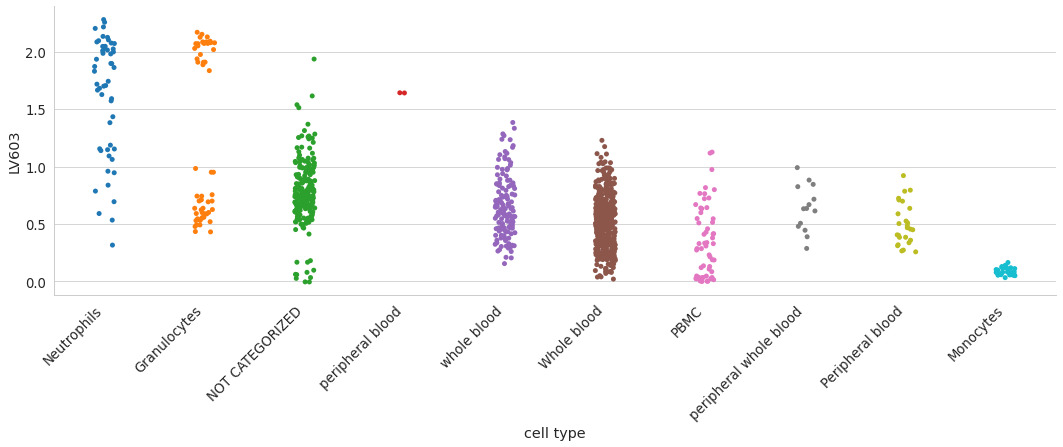

In [39]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTES[0],
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

#     plt.savefig(
#         OUTPUT_CELL_TYPE_FILEPATH,
#         bbox_inches="tight",
#         facecolor="white",
#     )

# Debug

In [40]:
with pd.option_context(
    "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
):
    _tmp = final_plot_data[
        final_plot_data[SELECTED_ATTRIBUTES[0]].str.contains("NOT CAT")
    ]
    display(_tmp.head(20))

cell type     LV603
project   run                                  
SRP015360 SRR553460   NOT CATEGORIZED  1.936240
          SRR553463   NOT CATEGORIZED  1.614990
          SRR553461   NOT CATEGORIZED  1.538253
SRP051848 SRR1747386  NOT CATEGORIZED  1.512612
SRP015360 SRR553464   NOT CATEGORIZED  1.368832
SRP051848 SRR1747242  NOT CATEGORIZED  1.313651
          SRR1747230  NOT CATEGORIZED  1.283074
SRP017138 SRR616078   NOT CATEGORIZED  1.267509
SRP051848 SRR1747372  NOT CATEGORIZED  1.266037
          SRR1747348  NOT CATEGORIZED  1.257565
          SRR1747322  NOT CATEGORIZED  1.253071
          SRR1747312  NOT CATEGORIZED  1.247533
          SRR1747314  NOT CATEGORIZED  1.241307
          SRR1747248  NOT CATEGORIZED  1.211017
          SRR1747264  NOT CATEGORIZED  1.169013
          SRR1747304  NOT CATEGORIZED  1.164252
          SRR1747275  NOT CATEGORIZED  1.160602
          SRR1747247  NOT CATEGORIZED  1.129323
          SRR1747321  NOT CATEGORIZED  1.116180
          SRR1747232  NOT CATEGORIZED  1.098986

In [41]:
# what is there in these projects?
lv_data.loc[["SRP015360"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).head(60)

age   Sex                                   treatment  \
project   run                                                               
SRP015360 SRR553460  30  male                                        none   
          SRR553463  58  male                                        none   
          SRR553461  30  male  incubated for 1h with TNF-alpha (10 ng/mL)   
          SRR553464  58  male  incubated for 1h with TNF-alpha (10 ng/mL)   
          SRR553462  30  male      incubated for 1h with GM-CSF (5 ng/mL)   
          SRR553465  58  male      incubated for 1h with GM-CSF (5 ng/mL)   

                        LV603  
project   run                  
SRP015360 SRR553460  1.936240  
          SRR553463  1.614990  
          SRR553461  1.538253  
          SRR553464  1.368832  
          SRR553462  1.016750  
          SRR553465  0.798007